# KRX 데이터를 활용한 포트폴리오

## Introduction

Data : 전자공시시스템에서 제공하는 분기별 재무제표 계정과목  
Date : 18년도 4분기(18Y 4Q) ~ 22년도 1분기(22Y 1Q)  
<br>반도체 섹터에 해당하는 134개의 종목 중 46종목(더 예쁘게 쓰고 싶은데 새벽이라 뇌정지옴)

### 패키지 로드

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd '/content/drive/MyDrive/krx 공모전/data'

/content/drive/MyDrive/krx 공모전/data


In [ ]:
!ls

catboost_info		data.xlsx      spag1.xlsx
data_0305_20220720.csv	for_test.xlsx  spag2.xlsx


In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from glob import glob
import pandas as pd
import numpy as np

# 시각화 라이브러리
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import plotly.express as px
import plotly.graph_objects as go

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import AdaBoostRegressor

In [ ]:
#한글 깨짐 처리
#step1 나눔 폰트 설치
#!sudo apt-get install -y fonts-nanum
#!sudo fc-cache -fv
#!rm ~/.cache/matplotlib -rf
plt.rc('font', family='NanumBarunGothic') 

### 함수

In [ ]:
# Sublineplot
def subplots(data,cols,nrow,ncol,title):
  df = data[cols]
  fig, ax = plt.subplots(nrow, ncol, figsize=(6*ncol,5*nrow))
  plt.suptitle(title, y=0.92, size=30)
  i=0
  for col in cols:
    ax[i//ncol,i%ncol].plot(df[col])
    ax[i//ncol,i%ncol].set_ylabel(col)
    i+=1  
  
# lineplot
def lineplot(data,cols,title):
  df = data[cols]
  plt.figure(figsize=(20,10))
  plt.title(title, y=1.05, size=25)
  for col in cols:
    plt.plot(df[col], label=col)
  plt.legend(loc='upper right')  

# corr_matrix
def corr_matrix(data, cols, title):
  df = data[cols]
  colormap = plt.cm.PuBu 
  plt.figure(figsize=(12, 12)) 
  plt.title(title, y=1.05, size=20)
  sns.heatmap(df.astype(float).corr(), linewidths = 0.1, vmax = 1.0,
              square = True, cmap = colormap, linecolor = "white", annot = True, fmt='.2f',
              annot_kws = {"size" : 12})
  plt.show()

# IQR Based Outlier Processing Function Definition
def outliers_iqr(data):
  q1,q3 = np.percentile(data,[25,75])
  iqr=q3-q1
  lower_bound=  q1 - (iqr *1.5)
  upper_bound = q3 + (iqr *1.5)
  data[data>upper_bound] = np.nan #np.mean(data)
  data[data<lower_bound] = np.nan #np.mean(data)
  data.interpolate(method="ffill", inplace=True)
  data.interpolate(method="bfill", inplace=True)
  return data

### 데이터 로드

In [ ]:
filst = sorted(glob('*.xlsx'))
filst

['data.xlsx', 'for_test.xlsx', 'spag1.xlsx', 'spag2.xlsx']

In [ ]:
data = pd.read_excel(filst[0])
data.head(5)

,분기,종목,자산총계,자본총계,부채총계,매출액,영업이익,당기순이익
0,18Y4Q,유진테크,2.915668e+11,2.634519e+11,2.811489e+10,3.509194e+10,1.068125e+10,2.821543e+08
1,19Y1Q,유진테크,3.069190e+11,2.688406e+11,3.807837e+10,4.282116e+10,1.381908e+10,1.124246e+10
2,19Y2Q,유진테크,3.165687e+11,2.894235e+11,2.714527e+10,6.550883e+10,2.563682e+10,2.077325e+10
3,19Y3Q,유진테크,3.263077e+11,2.984114e+11,2.789634e+10,3.962203e+10,8.644441e+09,9.101949e+09
4,19Y4Q,유진테크,3.185496e+11,2.912752e+11,2.727444e+10,2.623418e+10,-2.851466e+09,-8.300271e+09


## Data processing

### 기업분석 지표<br>
기업분석에 활용되는 지표를 특성별로 2가지씩 사용<br>
- 안정성 : 부채비율 , 자기자본비율  
- 수익성 : 매출액순이익률, 매출액영업이익률  
- 활동성 : 총자산회전율, 자기자본회전율  
- 성장성 : 영업이익증가율, 순이익증가율<br><br>

In [ ]:
#안정성
data['부채비율'] = data['부채총계']/data['자본총계']*100
data['자기자본비율'] = data['자본총계']/data['자산총계']*100
#data['총자산순이익률'] = data['당기순이익']/data['자산총계']*100
#수익성
data['매출액순이익률'] = data['당기순이익']/data['매출액']*100
data['매출액영업이익률'] = data['영업이익']/ data['매출액'] *100
#활동성
data['총자산회전율'] = data['매출액']/data['자산총계']
data['자기자본회전율']= data['매출액']/ data['자본총계']

#성장성
data['영업이익증가율']=np.NaN
data['순이익증가율'] =np.NaN
for i in range(len(data)-1):
  data['영업이익증가율'][i+1]=(data['영업이익'][i+1]-data['영업이익'][i])/data['영업이익'][i]*100
  data['순이익증가율'][i+1]= (data['당기순이익'][i+1]-data['당기순이익'][i])/data['당기순이익'][i]*100

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### 데이터 프레임 생성  
 
반도체 기업별 주요계정(Major Accounts of the Semiconductor companies, MAS)
- MAS : 18년도 4분기(18Y 4Q) ~ 22년도 1분기(22Y 1Q) 6가지 주요계정  

기업 분석 지표(Business Analysis Indicator, BAI)  
- BAI : 18년도 4분기(18Y 4Q) ~ 22년도 1분기(22Y 1Q) 8가지 기업분석 지표

In [ ]:
mas = data[['분기','종목','자산총계','자본총계','부채총계','매출액','영업이익','당기순이익']]
bai = data[['분기','종목','부채비율','자기자본비율','매출액순이익률','매출액영업이익률','총자산회전율','자기자본회전율','영업이익증가율','순이익증가율']]
#spag = data[['분기','종목','안정성','수익성','활동성','성장성']]

### 결측치 제거
성장성의 경우, 전 분기 순이익 데이터를 사용하기 때문에 18년도 4분기의 성장성을 구할 수 없음

In [ ]:
#18년도 4분기 제거
index1=bai[bai['분기']=='18Y4Q'].index
bai.drop(index1,inplace=True)
#인덱싱 재배열
bai.reset_index(inplace=True)
bai.drop(['index'],axis=1,inplace=True)
bai.head(2)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,분기,종목,부채비율,자기자본비율,매출액순이익률,매출액영업이익률,총자산회전율,자기자본회전율,영업이익증가율,순이익증가율
0,19Y1Q,유진테크,14.163922,87.593347,26.254461,32.271622,0.139519,0.159281,29.377048,3884.509365
1,19Y2Q,유진테크,9.379083,91.425159,31.710609,39.134906,0.206934,0.226343,85.517542,84.774894


### 시각화

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51088 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48376 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52509 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44228 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51088 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backe

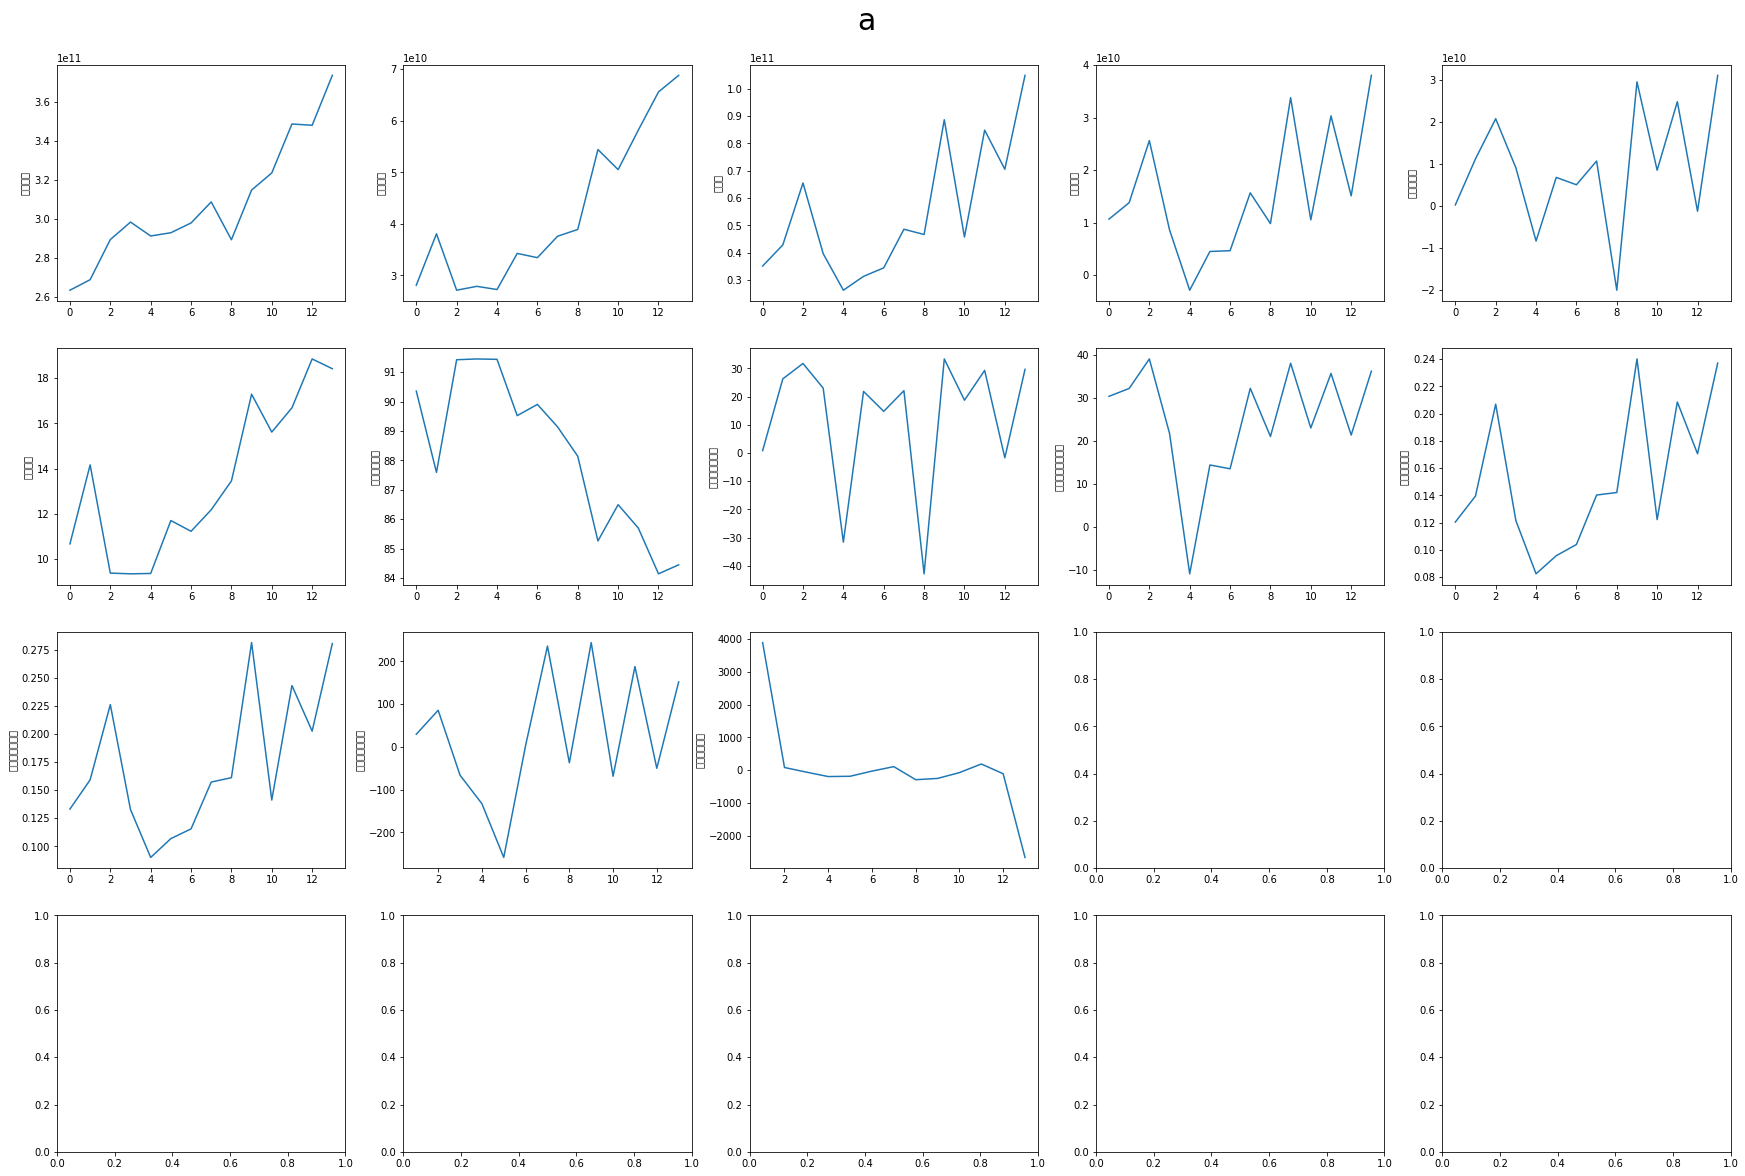

In [ ]:
subplots(data[data['종목']=='유진테크'],data[data['종목']=='유진테크'].columns[3:],4,5,'a')

### Data Scaling  
RobustScaler  
이상치의 영향을 최소화하기 위해서 중간값(median)과 사분위값(quartile)을 사용하는 **RobustScaler**를 사용했습니다.

In [ ]:
rb_bai = bai.iloc[:,2:]
rb_bai.head(2)
scaler = RobustScaler()
scaler.fit(rb_bai)
colnames = rb_bai.columns
new_colnames = [i for i in colnames]

In [ ]:
bai_RS = pd.concat([bai.iloc[:,:2],pd.DataFrame(scaler.fit_transform(rb_bai[colnames]),columns=new_colnames)],axis=1)
bai_RS.head(2)

,분기,종목,부채비율,자기자본비율,매출액순이익률,매출액영업이익률,총자산회전율,자기자본회전율,영업이익증가율,순이익증가율
0,19Y1Q,유진테크,-0.424816,0.578992,0.856453,1.197120,-0.341300,-0.487426,0.328018,30.088515
1,19Y2Q,유진테크,-0.501623,0.713758,1.169686,1.595622,0.220635,-0.185864,0.861672,0.745940


In [ ]:
item = data['종목'].unique()

## Modeling

위에서 얻은 당기 6가지 주요계정(MAS)을 독립변수로, 차기 8가지 기업분석 지표(BAI)를 각각의 종속변수로 하는 8개의 회귀 모델  
<br>독립변수(X) : 19년도 1분기(19Y 1Q) ~ 21년도 3분기(21Y 3Q)
<br>종속변수(Y) : 19년도 2분기(19Y 2Q) ~ 21년도 4분기(21Y 4Q)

### Model 구성을 위한 함수 정의

In [ ]:
def bai_(name,i):
  mas_select = mas[mas['종목']==name]
  bai_select = bai[bai['종목']==name]
  bai_select = bai_select[0:12]
  mas_select_X = mas_select[:12]
  mas_select_x= mas_select[12:13]

  X = mas_select_X.iloc[:,2:8]
  Y = bai_select.iloc[:,i]
  x = mas_select_x.iloc[:,2:8]
  return X,Y,x


#### 안정성  
- 부채비율 
- 자기자본비율 

In [ ]:
# 안정성
# 부채비율
def stability_1(name):
  X,Y,x= bai_(name,2)
  return X,Y,x

# 자기자본비율
def stability_2(name):
  X,Y,x= bai_(name,3)
  return X,Y,x

#### 수익성
- 매출액순이익률
- 매출액영업이익률

In [ ]:
# 수익성
# 매출액순이익률
def profitability_1(name):
  X,Y,x= bai_(name,4)
  return X,Y,x

# 매출액영업이익률
def profitability_2(name):
  X,Y,x= bai_(name,5)
  return X,Y,x

#### 활동성
- 총자산회전율
- 자기자본회전율

In [ ]:
# 활동성
# 총자산회전율
def activity_1(name):
  X,Y,x= bai_(name,6)
  return X,Y,x
# 자기자본회전율
def activity_2(name):
  X,Y,x= bai_(name,7)
  return X,Y,x

#### 성장성
- 영업이익증가율
- 순이익증가율

In [ ]:
# 성장성
# 영업이익증가율
def growth_1(name):
  X,Y,x= bai_(name,8)
  return X,Y,x

# 순이익증가율
def growth_2(name):
  X,Y,x= bai_(name,9)
  return X,Y,x

### Regression

In [ ]:
def linear_model(X,Y,x):
  line_fitter = LinearRegression()
  line_fitter.fit(X,Y)
  y_predicted_s = line_fitter.predict(x)
  return y_predicted_s

def XGB_model(X,Y,x):
  XGB_fitter = XGBRegressor()
  XGB_fitter.fit(X,Y)
  y_predicted_s = XGB_fitter.predict(x)
  return y_predicted_s

def CB_model(X,Y,x):
  CB_fitter = CatBoostRegressor()
  CB_fitter.fit(X,Y)
  y_predicted_s = CB_fitter.predict(x)
  return y_predicted_s

def AB_model(X,Y,x):
  AB_fitter = AdaBoostRegressor()
  AB_fitter.fit(X,Y)
  y_predicted_s = AB_fitter.predict(x)
  return y_predicted_s

def LGBM_model(X,Y,x):
  LGBM_fitter = LGBMRegressor()
  LGBM_fitter.fit(X,Y)
  y_predicted_s = LGBM_fitter.predict(x)
  return y_predicted_s

def GP_model(X,Y,x):
  GP_fitter = GaussianProcessRegressor()
  GP_fitter.fit(X,Y)
  y_predicted_s = GP_fitter.predict(x)
  return y_predicted_s

훈련 세트  
- MAS : 19년도 1분기(19Y 1Q) ~ 21년도 3분기(21Y 3Q) 
- BAI : 19년도 2분기(19Y 2Q) ~ 21년도 4분기(21Y 4Q)   

테스트 세트
- MAS : 21년도 4분기(21Y 4Q) 
- BAI : 22년도 1분기(22Y 1Q)

#### LinearRegression 모델  


In [ ]:
def linear_model_s1(name):
  X,Y,x=stability_1(name)
  y_predicted_s=linear_model(X,Y,x)
  return y_predicted_s

def linear_model_s2(name):
  X,Y,x=stability_2(name)
  y_predicted_s=linear_model(X,Y,x)
  return y_predicted_s

def linear_model_p1(name):
  X,Y,x=profitability_1(name)
  y_predicted_s=linear_model(X,Y,x)
  return y_predicted_s

def linear_model_p2(name):
  X,Y,x=profitability_2(name)
  y_predicted_s=linear_model(X,Y,x)
  return y_predicted_s

def linear_model_a1(name):
  X,Y,x=activity_1(name)
  y_predicted_s=linear_model(X,Y,x)
  return y_predicted_s

def linear_model_a2(name):
  X,Y,x=activity_2(name)
  y_predicted_s=linear_model(X,Y,x)
  return y_predicted_s

def linear_model_g1(name):
  X,Y,x=growth_1(name)
  y_predicted_s=linear_model(X,Y,x)
  return y_predicted_s

def linear_model_g2(name):
  X,Y,x=growth_2(name)
  y_predicted_s=linear_model(X,Y,x)
  return y_predicted_s

##### Model 실행

In [ ]:
s1,s2,p1,p2,a1,a2,g1,g2=[],[],[],[],[],[],[],[]
for i in item :
  s1.append(linear_model_s1(i))
  s2.append(linear_model_s2(i))
  p1.append(linear_model_p1(i))
  p2.append(linear_model_p2(i)) 
  a1.append(linear_model_a1(i))
  a2.append(linear_model_a2(i))
  g1.append(linear_model_g1(i)) 
  g2.append(linear_model_g2(i)) 

##### Data merge

In [ ]:
C= pd.DataFrame(item,columns=['종목'])
S1= pd.DataFrame(s1,columns=['부채비율'])
S2= pd.DataFrame(s2,columns=['자기자본비율'])
P1= pd.DataFrame(p1,columns=['매출액순이익률'])
P2= pd.DataFrame(p2,columns=['매출액영업이익률'])
A1= pd.DataFrame(a1,columns=['총자산회전율'])
A2= pd.DataFrame(a2,columns=['자기자본회전율'])
G1= pd.DataFrame(g1,columns=['영업이익증가율'])
G2= pd.DataFrame(g2,columns=['순이익증가율'])

In [ ]:
predict_LIN = pd.concat([C,S1,S2,P1,P2,A1,A2,G1,G2],axis=1)
predict_LIN = predict_LIN[['부채비율','자기자본비율','매출액순이익률','매출액영업이익률','총자산회전율','자기자본회전율','영업이익증가율','순이익증가율']]

actual_LIN =  bai[(bai['분기']=='22Y1Q')|(bai['분기']== '22Y 1Q')]
actual_LIN.reset_index(inplace=True)
actual_LIN = actual_LIN[['부채비율','자기자본비율','매출액순이익률','매출액영업이익률','총자산회전율','자기자본회전율','영업이익증가율','순이익증가율']]

#### XGBoost

In [ ]:
def XGB_model_s1(name):
  X,Y,x=stability_1(name)
  y_predicted_s=XGB_model(X,Y,x)
  return y_predicted_s

def XGB_model_s2(name):
  X,Y,x=stability_2(name)
  y_predicted_s=XGB_model(X,Y,x)
  return y_predicted_s

def XGB_model_p1(name):
  X,Y,x=profitability_1(name)
  y_predicted_s=XGB_model(X,Y,x)
  return y_predicted_s

def XGB_model_p2(name):
  X,Y,x=profitability_2(name)
  y_predicted_s=XGB_model(X,Y,x)
  return y_predicted_s

def XGB_model_a1(name):
  X,Y,x=activity_1(name)
  y_predicted_s=XGB_model(X,Y,x)
  return y_predicted_s

def XGB_model_a2(name):
  X,Y,x=activity_2(name)
  y_predicted_s=XGB_model(X,Y,x)
  return y_predicted_s

def XGB_model_g1(name):
  X,Y,x=growth_1(name)
  y_predicted_s=XGB_model(X,Y,x)
  return y_predicted_s

def XGB_model_g2(name):
  X,Y,x=growth_2(name)
  y_predicted_s=XGB_model(X,Y,x)
  return y_predicted_s

##### Model 실행

In [ ]:
s1,s2,p1,p2,a1,a2,g1,g2=[],[],[],[],[],[],[],[]
for i in item :
  s1.append(XGB_model_s1(i))
  s2.append(XGB_model_s2(i))
  p1.append(XGB_model_p1(i))
  p2.append(XGB_model_p2(i)) 
  a1.append(XGB_model_a1(i))
  a2.append(XGB_model_a2(i))
  g1.append(XGB_model_g1(i)) 
  g2.append(XGB_model_g2(i)) 

[14:16:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:16:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:16:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:16:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:16:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:16:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:16:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:16:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

##### Data merge

In [ ]:
C= pd.DataFrame(item,columns=['종목'])
S1= pd.DataFrame(s1,columns=['부채비율'])
S2= pd.DataFrame(s2,columns=['자기자본비율'])
P1= pd.DataFrame(p1,columns=['매출액순이익률'])
P2= pd.DataFrame(p2,columns=['매출액영업이익률'])
A1= pd.DataFrame(a1,columns=['총자산회전율'])
A2= pd.DataFrame(a2,columns=['자기자본회전율'])
G1= pd.DataFrame(g1,columns=['영업이익증가율'])
G2= pd.DataFrame(g2,columns=['순이익증가율'])

In [ ]:
predict_XGB = pd.concat([C,S1,S2,P1,P2,A1,A2,G1,G2],axis=1)
predict_XGB = predict_XGB[['부채비율','자기자본비율','매출액순이익률','매출액영업이익률','총자산회전율','자기자본회전율','영업이익증가율','순이익증가율']]

actual_XGB =  bai[(bai['분기']=='22Y1Q')|(bai['분기']== '22Y 1Q')]
actual_XGB.reset_index(inplace=True)
actual_XGB = actual_XGB[['부채비율','자기자본비율','매출액순이익률','매출액영업이익률','총자산회전율','자기자본회전율','영업이익증가율','순이익증가율']]

#### CatBoost

In [ ]:
def CB_model_s1(name):
  X,Y,x=stability_1(name)
  y_predicted_s=CB_model(X,Y,x)
  return y_predicted_s

def CB_model_s2(name):
  X,Y,x=stability_2(name)
  y_predicted_s=CB_model(X,Y,x)
  return y_predicted_s

def CB_model_p1(name):
  X,Y,x=profitability_1(name)
  y_predicted_s=CB_model(X,Y,x)
  return y_predicted_s

def CB_model_p2(name):
  X,Y,x=profitability_2(name)
  y_predicted_s=CB_model(X,Y,x)
  return y_predicted_s

def CB_model_a1(name):
  X,Y,x=activity_1(name)
  y_predicted_s=CB_model(X,Y,x)
  return y_predicted_s

def CB_model_a2(name):
  X,Y,x=activity_2(name)
  y_predicted_s=CB_model(X,Y,x)
  return y_predicted_s

def CB_model_g1(name):
  X,Y,x=growth_1(name)
  y_predicted_s=CB_model(X,Y,x)
  return y_predicted_s

def CB_model_g2(name):
  X,Y,x=growth_2(name)
  y_predicted_s=CB_model(X,Y,x)
  return y_predicted_s

##### Model 실행

In [ ]:
s1,s2,p1,p2,a1,a2,g1,g2=[],[],[],[],[],[],[],[]
for i in item :
  s1.append(CB_model_s1(i))
  s2.append(CB_model_s2(i))
  p1.append(CB_model_p1(i))
  p2.append(CB_model_p2(i)) 
  a1.append(CB_model_a1(i))
  a2.append(CB_model_a2(i))
  g1.append(CB_model_g1(i)) 
  g2.append(CB_model_g2(i)) 

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
4:	learn: 6.5290192	total: 1.6ms	remaining: 318ms
5:	learn: 6.4863239	total: 1.89ms	remaining: 313ms
6:	learn: 6.4197149	total: 2.04ms	remaining: 289ms
7:	learn: 6.3769539	total: 2.45ms	remaining: 304ms
8:	learn: 6.3333071	total: 2.82ms	remaining: 311ms
9:	learn: 6.2929965	total: 3.15ms	remaining: 312ms
10:	learn: 6.2469231	total: 3.41ms	remaining: 306ms
11:	learn: 6.2068127	total: 3.75ms	remaining: 308ms
12:	learn: 6.1783858	total: 4.06ms	remaining: 308ms
13:	learn: 6.1298955	total: 4.32ms	remaining: 304ms
14:	learn: 6.0810150	total: 4.54ms	remaining: 298ms
15:	learn: 6.0552730	total: 4.7ms	remaining: 289ms
16:	learn: 6.0011055	total: 4.89ms	remaining: 283ms
17:	learn: 5.9627593	total: 5.04ms	remaining: 275ms
18:	learn: 5.9232837	total: 5.31ms	remaining: 274ms
19:	learn: 5.8638826	total: 5.76ms	remaining: 282ms
20:	learn: 5.8291996	total: 6.06ms	remaining: 283ms
21:	learn: 5.7929162	total: 6.36ms	remaining: 283ms
22:	learn: 5.7561179	total: 6.66ms	r

#####Data merge

In [ ]:
C= pd.DataFrame(item,columns=['종목'])
S1= pd.DataFrame(s1,columns=['부채비율'])
S2= pd.DataFrame(s2,columns=['자기자본비율'])
P1= pd.DataFrame(p1,columns=['매출액순이익률'])
P2= pd.DataFrame(p2,columns=['매출액영업이익률'])
A1= pd.DataFrame(a1,columns=['총자산회전율'])
A2= pd.DataFrame(a2,columns=['자기자본회전율'])
G1= pd.DataFrame(g1,columns=['영업이익증가율'])
G2= pd.DataFrame(g2,columns=['순이익증가율'])

In [ ]:
predict_CB = pd.concat([C,S1,S2,P1,P2,A1,A2,G1,G2],axis=1)
predict_CB = predict_CB[['부채비율','자기자본비율','매출액순이익률','매출액영업이익률','총자산회전율','자기자본회전율','영업이익증가율','순이익증가율']]

actual_CB =  bai[(bai['분기']=='22Y1Q')|(bai['분기']== '22Y 1Q')]
actual_CB.reset_index(inplace=True)
actual_CB = actual_CB[['부채비율','자기자본비율','매출액순이익률','매출액영업이익률','총자산회전율','자기자본회전율','영업이익증가율','순이익증가율']]

#### AdaBoost

In [ ]:
def AB_model_s1(name):
  X,Y,x=stability_1(name)
  y_predicted_s=AB_model(X,Y,x)
  return y_predicted_s

def AB_model_s2(name):
  X,Y,x=stability_2(name)
  y_predicted_s=AB_model(X,Y,x)
  return y_predicted_s

def AB_model_p1(name):
  X,Y,x=profitability_1(name)
  y_predicted_s=AB_model(X,Y,x)
  return y_predicted_s

def AB_model_p2(name):
  X,Y,x=profitability_2(name)
  y_predicted_s=AB_model(X,Y,x)
  return y_predicted_s

def AB_model_a1(name):
  X,Y,x=activity_1(name)
  y_predicted_s=AB_model(X,Y,x)
  return y_predicted_s

def AB_model_a2(name):
  X,Y,x=activity_2(name)
  y_predicted_s=AB_model(X,Y,x)
  return y_predicted_s

def AB_model_g1(name):
  X,Y,x=growth_1(name)
  y_predicted_s=AB_model(X,Y,x)
  return y_predicted_s

def AB_model_g2(name):
  X,Y,x=growth_2(name)
  y_predicted_s=AB_model(X,Y,x)
  return y_predicted_s

##### Model 실행

In [ ]:
s1,s2,p1,p2,a1,a2,g1,g2=[],[],[],[],[],[],[],[]
for i in item :
  s1.append(AB_model_s1(i))
  s2.append(AB_model_s2(i))
  p1.append(AB_model_p1(i))
  p2.append(AB_model_p2(i)) 
  a1.append(AB_model_a1(i))
  a2.append(AB_model_a2(i))
  g1.append(AB_model_g1(i)) 
  g2.append(AB_model_g2(i)) 

#####Data merge

In [ ]:
C= pd.DataFrame(item,columns=['종목'])
S1= pd.DataFrame(s1,columns=['부채비율'])
S2= pd.DataFrame(s2,columns=['자기자본비율'])
P1= pd.DataFrame(p1,columns=['매출액순이익률'])
P2= pd.DataFrame(p2,columns=['매출액영업이익률'])
A1= pd.DataFrame(a1,columns=['총자산회전율'])
A2= pd.DataFrame(a2,columns=['자기자본회전율'])
G1= pd.DataFrame(g1,columns=['영업이익증가율'])
G2= pd.DataFrame(g2,columns=['순이익증가율'])

In [ ]:
predict_AB = pd.concat([C,S1,S2,P1,P2,A1,A2,G1,G2],axis=1)
predict_AB = predict_AB[['부채비율','자기자본비율','매출액순이익률','매출액영업이익률','총자산회전율','자기자본회전율','영업이익증가율','순이익증가율']]

actual_AB =  bai[(bai['분기']=='22Y1Q')|(bai['분기']== '22Y 1Q')]
actual_AB.reset_index(inplace=True)
actual_AB = actual_AB[['부채비율','자기자본비율','매출액순이익률','매출액영업이익률','총자산회전율','자기자본회전율','영업이익증가율','순이익증가율']]

#### LGBM

In [ ]:
def LGBM_model_s1(name):
  X,Y,x=stability_1(name)
  y_predicted_s=LGBM_model(X,Y,x)
  return y_predicted_s

def LGBM_model_s2(name):
  X,Y,x=stability_2(name)
  y_predicted_s=LGBM_model(X,Y,x)
  return y_predicted_s

def LGBM_model_p1(name):
  X,Y,x=profitability_1(name)
  y_predicted_s=LGBM_model(X,Y,x)
  return y_predicted_s

def LGBM_model_p2(name):
  X,Y,x=profitability_2(name)
  y_predicted_s=LGBM_model(X,Y,x)
  return y_predicted_s

def LGBM_model_a1(name):
  X,Y,x=activity_1(name)
  y_predicted_s=LGBM_model(X,Y,x)
  return y_predicted_s

def LGBM_model_a2(name):
  X,Y,x=activity_2(name)
  y_predicted_s=LGBM_model(X,Y,x)
  return y_predicted_s

def LGBM_model_g1(name):
  X,Y,x=growth_1(name)
  y_predicted_s=LGBM_model(X,Y,x)
  return y_predicted_s

def LGBM_model_g2(name):
  X,Y,x=growth_2(name)
  y_predicted_s=LGBM_model(X,Y,x)
  return y_predicted_s

##### Model 실행

In [ ]:
s1,s2,p1,p2,a1,a2,g1,g2=[],[],[],[],[],[],[],[]
for i in item :
  s1.append(LGBM_model_s1(i))
  s2.append(LGBM_model_s2(i))
  p1.append(LGBM_model_p1(i))
  p2.append(LGBM_model_p2(i)) 
  a1.append(LGBM_model_a1(i))
  a2.append(LGBM_model_a2(i))
  g1.append(LGBM_model_g1(i)) 
  g2.append(LGBM_model_g2(i)) 

#####Data merge

In [ ]:
C= pd.DataFrame(item,columns=['종목'])
S1= pd.DataFrame(s1,columns=['부채비율'])
S2= pd.DataFrame(s2,columns=['자기자본비율'])
P1= pd.DataFrame(p1,columns=['매출액순이익률'])
P2= pd.DataFrame(p2,columns=['매출액영업이익률'])
A1= pd.DataFrame(a1,columns=['총자산회전율'])
A2= pd.DataFrame(a2,columns=['자기자본회전율'])
G1= pd.DataFrame(g1,columns=['영업이익증가율'])
G2= pd.DataFrame(g2,columns=['순이익증가율'])

In [ ]:
predict_LGBM = pd.concat([C,S1,S2,P1,P2,A1,A2,G1,G2],axis=1)
predict_LGBM = predict_LGBM[['부채비율','자기자본비율','매출액순이익률','매출액영업이익률','총자산회전율','자기자본회전율','영업이익증가율','순이익증가율']]

actual_LGBM =  bai[(bai['분기']=='22Y1Q')|(bai['분기']== '22Y 1Q')]
actual_LGBM.reset_index(inplace=True)
actual_LGBM = actual_LGBM[['부채비율','자기자본비율','매출액순이익률','매출액영업이익률','총자산회전율','자기자본회전율','영업이익증가율','순이익증가율']]

#### Gausian Process

In [ ]:
def GP_model_s1(name):
  X,Y,x=stability_1(name)
  y_predicted_s=GP_model(X,Y,x)
  return y_predicted_s

def GP_model_s2(name):
  X,Y,x=stability_2(name)
  y_predicted_s=GP_model(X,Y,x)
  return y_predicted_s

def GP_model_p1(name):
  X,Y,x=profitability_1(name)
  y_predicted_s=GP_model(X,Y,x)
  return y_predicted_s

def GP_model_p2(name):
  X,Y,x=profitability_2(name)
  y_predicted_s=GP_model(X,Y,x)
  return y_predicted_s

def GP_model_a1(name):
  X,Y,x=activity_1(name)
  y_predicted_s=GP_model(X,Y,x)
  return y_predicted_s

def GP_model_a2(name):
  X,Y,x=activity_2(name)
  y_predicted_s=GP_model(X,Y,x)
  return y_predicted_s

def GP_model_g1(name):
  X,Y,x=growth_1(name)
  y_predicted_s=GP_model(X,Y,x)
  return y_predicted_s

def GP_model_g2(name):
  X,Y,x=growth_2(name)
  y_predicted_s=GP_model(X,Y,x)
  return y_predicted_s

##### Model 실행

In [ ]:
s1,s2,p1,p2,a1,a2,g1,g2=[],[],[],[],[],[],[],[]
for i in item :
  s1.append(GP_model_s1(i))
  s2.append(GP_model_s2(i))
  p1.append(GP_model_p1(i))
  p2.append(GP_model_p2(i)) 
  a1.append(GP_model_a1(i))
  a2.append(GP_model_a2(i))
  g1.append(GP_model_g1(i)) 
  g2.append(GP_model_g2(i)) 

#####Data merge

In [ ]:
C= pd.DataFrame(item,columns=['종목'])
S1= pd.DataFrame(s1,columns=['부채비율'])
S2= pd.DataFrame(s2,columns=['자기자본비율'])
P1= pd.DataFrame(p1,columns=['매출액순이익률'])
P2= pd.DataFrame(p2,columns=['매출액영업이익률'])
A1= pd.DataFrame(a1,columns=['총자산회전율'])
A2= pd.DataFrame(a2,columns=['자기자본회전율'])
G1= pd.DataFrame(g1,columns=['영업이익증가율'])
G2= pd.DataFrame(g2,columns=['순이익증가율'])

In [ ]:
predict_GP = pd.concat([C,S1,S2,P1,P2,A1,A2,G1,G2],axis=1)
predict_GP = predict_GP[['부채비율','자기자본비율','매출액순이익률','매출액영업이익률','총자산회전율','자기자본회전율','영업이익증가율','순이익증가율']]

actual_GP =  bai[(bai['분기']=='22Y1Q')|(bai['분기']== '22Y 1Q')]
actual_GP.reset_index(inplace=True)
actual_GP = actual_GP[['부채비율','자기자본비율','매출액순이익률','매출액영업이익률','총자산회전율','자기자본회전율','영업이익증가율','순이익증가율']]

### 평가 지표
모델의 성능 평가 지표로 이상치에 민감하지 않은 RMSE와 RMSLE를 모두 사용하였습니다.

#### RMSE

실제 값과 예측 값의 차이를 제곱하여 평균한 값인 MSE에 루트를 씌운 값

In [ ]:
from sklearn.metrics import mean_squared_error
def rmse(actual,predict):
  RMSE=[]
  for i in range(len(actual.columns)):
    RMSE_value = np.sqrt(mean_squared_error(actual.iloc[:,i],predict.iloc[:,i]))
    RMSE.append(RMSE_value)
  return RMSE

#### RMSLE

설명 필요

In [ ]:
RMSLE=[]
def rmsle2(actual,predict):
  def rmsle(y,pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred)**2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle
  for i in range(8):
    rmsle_value=rmsle(actual.iloc[:,i],predict.iloc[:,i])
    RMSLE.append(rmsle_value)
  return RMSLE

### 모델 비교

In [ ]:
rmse(actual_LIN,predict_LIN)

[62.100455322543596,
 14.613384586783809,
 116.05639101435261,
 29.41781271367664,
 0.07589613247697787,
 0.18998699857495785,
 7313.530327000558,
 7774.065645171713]

In [ ]:
rmse(actual_XGB,predict_XGB)

[23.019845788092617,
 5.786297646661445,
 33.01866739576112,
 11.720274289022207,
 0.05923396194042429,
 0.18506354606391026,
 1291.7466203761153,
 801.9698549670719]

In [ ]:
rmse(actual_CB,predict_CB)

[24.596413501982692,
 5.5756984315122695,
 20.82231907103389,
 7.456266746720677,
 0.05016040038388708,
 0.14234079568033978,
 1412.5021612275589,
 809.91087353786]

In [ ]:
rmse(actual_AB,predict_AB)

[23.359125055929706,
 5.693430805959636,
 24.638156914751903,
 7.9963363326006975,
 0.055019856111296034,
 0.17326350634506427,
 1325.7059821036187,
 1010.0508590016236]

In [ ]:
rmse(actual_LGBM,predict_LGBM)

[40.84135679821055,
 8.070284134563964,
 24.75492617441947,
 10.147990096607142,
 0.05793649768692242,
 0.17515070569196517,
 2781.312708756227,
 1899.705265229838]

In [ ]:
rmse(actual_GP,predict_GP)

[66.02657024897285,
 70.89902016255765,
 22.275529409098926,
 20.943805075146443,
 0.27863772026548034,
 0.5021693135933427,
 1470.4740855065243,
 491.8093883331775]

In [ ]:
rmsle2(actual_XGB,predict_XGB)

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


[0.23295665029952453,
 0.10066666811088196,
 1.0370922283986421,
 0.6022304806603862,
 0.043413532104253694,
 0.10556260859957949,
 2.0216870144119605,
 0.9566341149586802]

## 최종 모델 결정

설명필요 (최종 모델 결정 후 : 릿지, 라쏘, 엘라스틱, 가우시안 등)  

<br>독립변수(X) :6가지 주요계정 19년도 1분기(19Y 1Q) ~ 21년도 4분기(21Y 4Q)
<br>종속변수(Y) :기업분석 지표   19년도 2분기(19Y 2Q) ~ 22년도 1분기(22Y 1Q)

예측 최종 변수 : 22년도 2분기(22Y 2Q)

### Model 구성을 위한 함수 정의

In [ ]:
def bai_F(name,i):
  mas_select = mas[mas['종목']==name]
  bai_select = bai[bai['종목']==name]
  bai_select = bai_select[0:13]
  mas_select_X = mas_select[:13]
  mas_select_x= mas_select[13:14]

  X = mas_select_X.iloc[:,2:8]
  Y = bai_select.iloc[:,i]
  x = mas_select_x.iloc[:,2:8]
  return X,Y,x

#### 안정성  
- 부채비율 
- 자기자본비율 

In [ ]:
# 안정성
# 부채비율
def stability_1(name):
  X,Y,x= bai_F(name,2)
  return X,Y,x


# 자기자본비율
def stability_2(name):
  X,Y,x= bai_F(name,3)
  return X,Y,x

#### 수익성
- 매출액순이익률
- 매출액영업이익률

In [ ]:
# 수익성
# 매출액순이익률
def profitability_1(name):
  X,Y,x= bai_F(name,4)
  return X,Y,x

# 매출액영업이익률
def profitability_2(name):
  X,Y,x= bai_F(name,5)
  return X,Y,x

#### 활동성
- 총자산회전율
- 자기자본회전율

In [ ]:
# 활동성
# 총자산회전율
def activity_1(name):
  X,Y,x= bai_F(name,6)
  return X,Y,x

# 자기자본회전율
def activity_2(name):
  X,Y,x= bai_F(name,7)
  return X,Y,x

#### 성장성
- 영업이익증가율
- 순이익증가율

In [ ]:
# 성장성
# 영업이익증가율
def growth_1(name):
  X,Y,x= bai_F(name,8)
  return X,Y,x

# 순이익증가율
def growth_2(name):
  X,Y,x= bai_F(name,9)
  return X,Y,x

~~ 모델

In [ ]:
def linear_model_s1(name):
  X,Y,x=stability_1(name)
  line_fitter = LinearRegression()
  line_fitter.fit(X,Y)
  y_predicted_s = line_fitter.predict(x)
  return y_predicted_s

def linear_model_s2(name):
  X,Y,x=stability_2(name)
  line_fitter = LinearRegression()
  line_fitter.fit(X,Y)
  y_predicted_s = line_fitter.predict(x)
  return y_predicted_s

def linear_model_p1(name):
  X,Y,x=profitability_1(name)
  line_fitter = LinearRegression()
  line_fitter.fit(X,Y)
  y_predicted_p = line_fitter.predict(x)
  return y_predicted_p

def linear_model_p2(name):
  X,Y,x=profitability_2(name)
  line_fitter = LinearRegression()
  line_fitter.fit(X,Y)
  y_predicted_p = line_fitter.predict(x)
  return y_predicted_p

def linear_model_a1(name):
  X,Y,x=activity_1(name)
  line_fitter = LinearRegression()
  line_fitter.fit(X,Y)
  y_predicted_a = line_fitter.predict(x)
  return y_predicted_a

def linear_model_a2(name):
  X,Y,x=activity_2(name)
  line_fitter = LinearRegression()
  line_fitter.fit(X,Y)
  y_predicted_a = line_fitter.predict(x)
  return y_predicted_a

def linear_model_g1(name):
  X,Y,x=growth_1(name)
  line_fitter = LinearRegression()
  line_fitter.fit(X,Y)
  y_predicted_g = line_fitter.predict(x)
  return y_predicted_g

def linear_model_g2(name):
  X,Y,x=growth_2(name)
  line_fitter = LinearRegression()
  line_fitter.fit(X,Y)
  y_predicted_g = line_fitter.predict(x)
  return y_predicted_g

In [ ]:
s1,s2,p1,p2,a1,a2,g1,g2=[],[],[],[],[],[],[],[]

In [ ]:
for i in item :
  s1.append(linear_model_s1(i))
  s2.append(linear_model_s2(i))
  p1.append(linear_model_p1(i))
  p2.append(linear_model_p2(i)) 
  a1.append(linear_model_a1(i))
  a2.append(linear_model_a2(i))
  g1.append(linear_model_g1(i)) 
  g2.append(linear_model_g2(i)) 

In [ ]:
C= pd.DataFrame(item,columns=['종목'])
S1= pd.DataFrame(s1,columns=['부채비율'])
S2= pd.DataFrame(s2,columns=['자기자본비율'])
P1= pd.DataFrame(p1,columns=['매출액순이익률'])
P2= pd.DataFrame(p2,columns=['매출액영업이익률'])
A1= pd.DataFrame(a1,columns=['총자산회전율'])
A2= pd.DataFrame(a2,columns=['자기자본회전율'])
G1= pd.DataFrame(g1,columns=['영업이익증가율'])
G2= pd.DataFrame(g2,columns=['순이익증가율'])

In [ ]:
final_predict = pd.concat([C,S1,S2,P1,P2,A1,A2,G1,G2],axis=1)
final_predict.insert(loc=0,column='분기',value='22Y2Q')
final_predict.head()

,분기,종목,부채비율,자기자본비율,매출액순이익률,매출액영업이익률,총자산회전율,자기자본회전율,영업이익증가율,순이익증가율
0,22Y2Q,유진테크,19.711739,83.499821,-8.357240,20.016344,0.179265,0.211282,-25.125877,-2022.565858
1,22Y2Q,서울반도체,35.299114,74.018710,5.674988,5.546074,0.295910,0.401139,40.111409,381.643516
2,22Y2Q,SFA반도체,61.449086,62.445527,11.906026,9.101223,0.334649,0.523600,-94.282505,-41.739463
3,22Y2Q,RFHIC,44.203239,69.047756,-4.207806,-8.158249,0.025953,0.039408,-238.259350,413.441338
4,22Y2Q,덕산네오룩스,17.316942,85.193239,24.198118,27.282005,0.144725,0.169281,1.455992,3.960263


### 파이널
- final : 예측값 까지 넣었을 때의 데이터프레임

(설명 필요)

In [ ]:
final = pd.concat([bai,final_predict])
final.reset_index(inplace=True)
final.drop(['index'],axis=1,inplace=True)
final

,분기,종목,부채비율,자기자본비율,매출액순이익률,매출액영업이익률,총자산회전율,자기자본회전율,영업이익증가율,순이익증가율
0,19Y1Q,유진테크,14.163922,87.593347,26.254461,32.271622,0.139519,0.159281,29.377048,3884.509365
1,19Y2Q,유진테크,9.379083,91.425159,31.710609,39.134906,0.206934,0.226343,85.517542,84.774894
2,19Y3Q,유진테크,9.348283,91.450910,22.971940,21.817258,0.121425,0.132777,-66.281152,-56.184281
3,19Y4Q,유진테크,9.363805,91.437931,-31.639151,-10.869279,0.082355,0.090067,-132.986122,-191.192237
4,20Y1Q,유진테크,11.702848,89.523232,21.802297,14.458665,0.095657,0.106852,-258.714336,-182.217846
...,...,...,...,...,...,...,...,...,...,...
664,22Y2Q,고영,33.448997,74.435996,21.357056,20.397369,0.161078,0.213734,36.946086,114.146872
665,22Y2Q,하나머티리얼즈,59.104168,60.900535,25.578715,30.310522,0.184885,0.303004,37.815655,58.424179
666,22Y2Q,이녹스첨단소재,36.221941,70.737460,23.950835,25.788959,0.245474,0.303244,-34.786821,41.410424
667,22Y2Q,젬백스,10.431496,90.381803,2.031551,4.657977,0.101455,0.115677,277.159275,-741.086954


In [ ]:
a=pd.DataFrame(columns=['종목','부채비율','자기자본비율','매출액순이익률','매출액영업이익률','총자산회전율','자기자본회전율','영업이익증가율','순이익증가율'])
a

,종목,부채비율,자기자본비율,매출액순이익률,매출액영업이익률,총자산회전율,자기자본회전율,영업이익증가율,순이익증가율


In [ ]:
for i in item:
  df=final[final['종목']==i]
  df.reset_index(inplace=True) 
  df.drop(['종목','분기','index'],axis=1,inplace=True)
  q,w=0,1
  result=0
  for j in range(14):
    q=df.iloc[j]*w
    w+=0.25
    result+=q
  result = result/36.75
  result['종목']= i
  a=a.append(result,ignore_index=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
predict.head() ##22년도 2분기 예측값

NameError: ignored

In [ ]:
# 과거 데이터 + 현재 + 예측한 데이터 = 가중치 부여 데이터
# 22년도 2분기 예측값.
a-predict

In [ ]:
a #가중치 부여값

In [ ]:
a[a['부채비율']>=100]

### 시각화